<a href="https://colab.research.google.com/github/mioyn/AdvDataProg/blob/main/ClassificationMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.datasets import fetch_openml
"""Load the MNIST dataset from OpenML.

Returns:
    X: Features (images) as a numpy array.
    y: Labels (digits) as a numpy array.
"""
mnist = fetch_openml('mnist_784', as_frame=False)
X, y = mnist.data, mnist.target
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
y

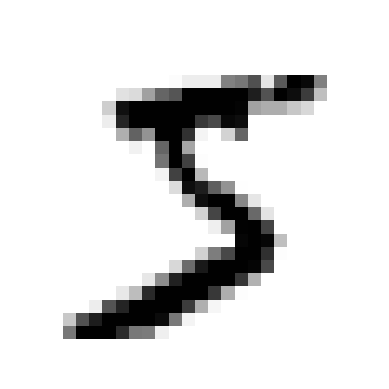

Label: 5


In [ ]:
import matplotlib.pyplot as plt
def plot_digit(data):
    """Plot a single digit from the MNIST dataset.

    Args:
        data: A 1D array of 784 pixel values representing a digit.
    """
    image = data.reshape(28, 28)
    plt.imshow(image, cmap='binary')
    plt.axis('off')

plot_digit(X[0])
plt.show()

print("Label:", y[0])

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
import numpy as np

# preprocessing = Pipeline(steps=[
#     ('scaler', StandardScaler()),
# ])

def scale_pixels(X):
    # Scale pixel values to [0.0, 1.0] range
    return np.asarray(X, dtype=np.float64) / 255.0

sgd_pipeline = Pipeline(steps=[
    ('normalizer', FunctionTransformer(scale_pixels)),
    ("classifier", SGDClassifier(random_state=42))
])

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

param_distributions = {
    'classifier__alpha': loguniform(1e-5, 1e-2),
    'classifier__penalty': ['l2', 'l1', 'elasticnet'],
    'classifier__loss': ['hinge', 'log_loss'],
    'classifier__max_iter': [1000, 2000, 3000],
    'classifier__learning_rate': ['optimal', 'adaptive'],
    'classifier__eta0': loguniform(1e-4, 1e-1)
}

random_search = RandomizedSearchCV(
    estimator=sgd_pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

print("Running RandomizedSearchCV...")
random_search.fit(X_train, y_train)
print("Search complete.")

Running RandomizedSearchCV...
Search complete.


In [ ]:
random_search.best_params_

{'classifier__alpha': np.float64(1.1527987128232396e-05),
 'classifier__eta0': np.float64(0.0812324508558869),
 'classifier__learning_rate': 'adaptive',
 'classifier__loss': 'log_loss',
 'classifier__max_iter': 2000,
 'classifier__penalty': 'l1'}

In [ ]:
final_model = random_search.best_estimator_


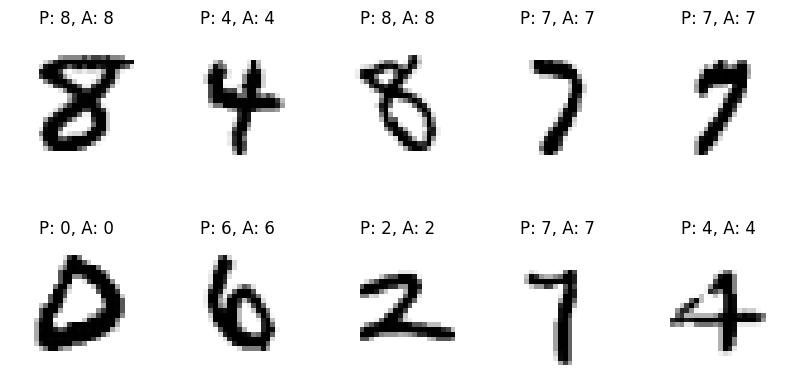

In [ ]:
y_pred = final_model.predict(X_test)
# print("Predicted digit:", y_pred[0])
# print("Actual digit:", y_test[0])

# plot_digit(X_test[0])
# plt.title(f"Predicted: {y_pred[0]}, Actual: {y_test[0]}")
# plt.show()

# Plot 10 image
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i].reshape(28, 28), cmap='binary')
    ax.set_title(f"P: {y_pred[i]}, A: {y_test[i]}")
    ax.axis('off')
plt.show()

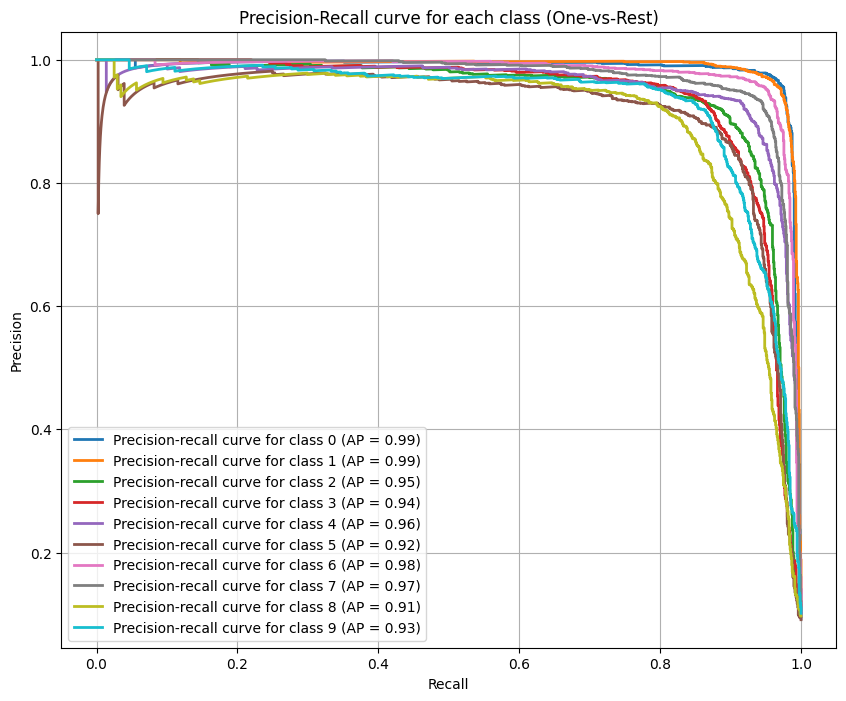

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import LabelBinarizer

# Get decision function scores or probabilities
# Since the best_params_ indicated 'log_loss', we use predict_proba
y_scores = final_model.predict_proba(X_test)

# Binarize the true labels for a one-vs-rest approach
label_binarizer = LabelBinarizer()
y_test_binarized = label_binarizer.fit_transform(y_test)

n_classes = y_test_binarized.shape[1]

# Plot Precision-Recall curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_scores[:, i])
    average_precision = average_precision_score(y_test_binarized[:, i], y_scores[:, i])

    plt.plot(recall, precision, lw=2, label=f'Precision-recall curve for class {label_binarizer.classes_[i]} (AP = {average_precision:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve for each class (One-vs-Rest)")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

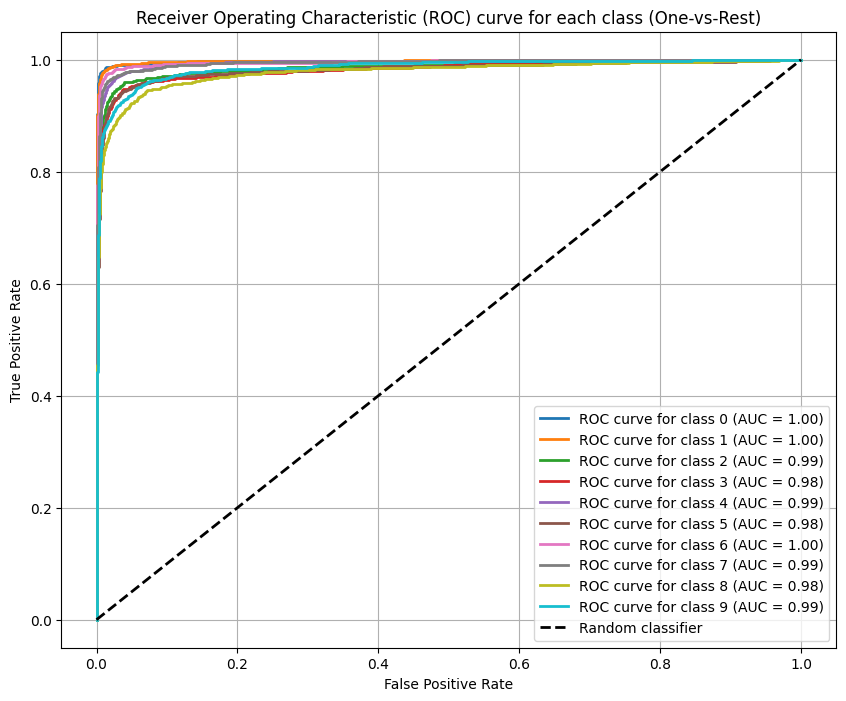

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f'ROC curve for class {label_binarizer.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random classifier')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) curve for each class (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

<Figure size 1000x800 with 0 Axes>

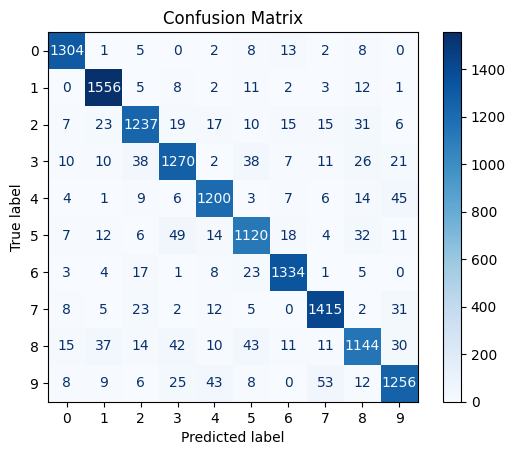

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

<Figure size 1000x800 with 0 Axes>

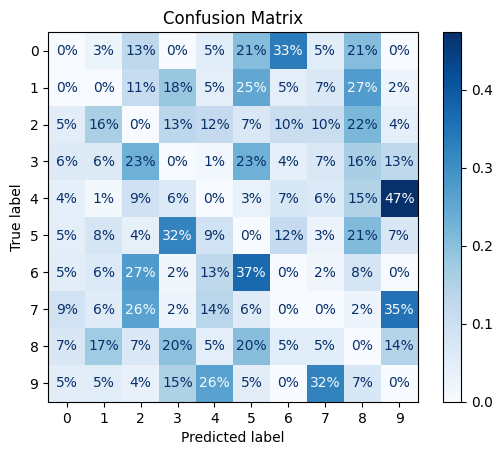

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
sample_weight = (y_pred != y_test)

plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', normalize="true", values_format=".0%", sample_weight=sample_weight)
plt.title('Confusion Matrix')
plt.show()

Running RandomizedSearchCV...
Search complete.


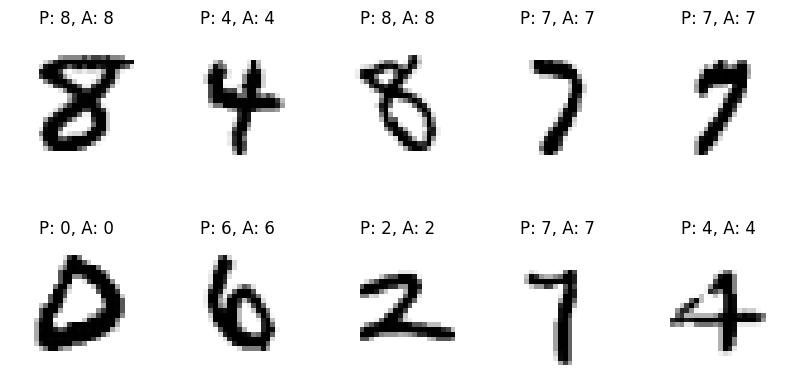

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA

kn_c_pipeline = Pipeline(steps=[
    ('normalizer', FunctionTransformer(scale_pixels)),
    ('pca', PCA(n_components=0.95)), # Keep 95% of variance
    ("classifier", KNeighborsClassifier())
])

# implement RandomizedSearchCV
param_distributions = {
    'classifier__n_neighbors': range(1, 5),
    'classifier__weights': ['uniform', 'distance'],
    'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'classifier__p': [1, 2] # 1 for Manhattan distance, 2 for Euclidean distance
}

random_search_kn = RandomizedSearchCV(
    estimator=kn_c_pipeline,
    param_distributions=param_distributions,
    n_iter=6,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

print("Running RandomizedSearchCV...")
random_search_kn.fit(X_train, y_train)
print("Search complete.")
random_search_kn.best_params_

y_pred = random_search_kn.best_estimator_.predict(X_test)

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i].reshape(28, 28), cmap='binary')
    ax.set_title(f"P: {y_pred[i]}, A: {y_test[i]}")
    ax.axis('off')
plt.show()

In [ ]:
random_search_kn.best_params_


{'classifier__weights': 'uniform',
 'classifier__p': 2,
 'classifier__n_neighbors': 3,
 'classifier__algorithm': 'kd_tree'}